In [1]:
# Installs all of the libraries present in the 'offline-pytorch-2-1-2' dataset
!pip install \
   --requirement /kaggle/input/offline-pytorch-2-1-2/requirements.txt \
   --no-index \
   --find-links file:///kaggle/input/offline-pytorch-2-1-2/wheels  \
--q

In [2]:
import os
os.system("wget -q https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget -q https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget -q https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget -q https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget -q https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

In [3]:
import koilerplate
print(f"koilerplate: {koilerplate.__version__}")

import torch
print(f"torch: {torch.__version__}")

import torchvision
print(f"torchvision: {torchvision.__version__}")

import torchaudio
print(f"torchaudio: {torchaudio.__version__}")

import torchdata
print(f"torchdata: {torchdata.__version__}")

import torchtext
print(f"torchtext: {torchtext.__version__}")

koilerplate: 0.1.3
torch: 2.1.2+cu118
torchvision: 0.16.2+cu118
torchaudio: 2.1.2+cu118
torchdata: 0.7.1+cpu
torchtext: 0.16.2+cpu


In [4]:
!pip install pycocotools --quiet

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed

import pandas as pd # data processing
import numpy as np
# Data Visulization libraries 
import matplotlib.pyplot as plt 
import seaborn as sns 
from torchvision.io import read_image
from torchvision.tv_tensors import BoundingBoxes, Image
from torchvision.transforms.v2 import functional as F

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
files_dir = '/kaggle/input/bee-detection-dataset'

temp1 = ['/train/images/'+image for image in sorted(os.listdir(files_dir+'/train/images'))
                        if (image[-4:]=='.jpg') and (image[:-4]+'.txt' in os.listdir(files_dir+'/train/labels'))
         and os.path.getsize(files_dir+'/train/labels/'+image[:-4]+'.txt') != 0]
temp2 = ['/train/labels/'+annot for annot in sorted(os.listdir(files_dir+'/train/labels'))
                        if (annot[-4:]=='.txt') and os.path.getsize(files_dir+'/train/labels/'+annot) != 0]

images = pd.Series(temp1, name='images')
image_id = pd.Series(list(range(len(temp1))), name='id')
train_img_df = pd.DataFrame(pd.concat([images, image_id], axis=1))
images = []
image_id = []
for i in range(len(temp1)):
    with open(files_dir + temp2[i], 'r') as file:
        for j in range(len(file.readlines())):
            images.append(temp1[i])
            image_id.append(i)
        file.close()
bboxes = []
for i in range(len(temp1)):
    with open(files_dir + temp2[i], 'r') as file:
        for line in file.readlines():
            bboxes.append(list(map(float, line.split())))
        file.close()
images = pd.Series(images, name='images')
bboxes = pd.Series(bboxes, name='bboxes')
image_id = pd.Series(image_id, name='image_id')
ind = pd.Series(list(range(len(images))), name='id')
df = pd.concat([images, ind,image_id,bboxes], axis=1)
train_df = pd.DataFrame(df)
area = []
for i in range(train_df.shape[0]):
    area.append(train_df.iloc[i,3][3]*train_df.iloc[i,3][4])
train_df = pd.concat([train_df, pd.Series(area, name='area')],axis=1)

In [7]:
train_df.head()

,images,id,image_id,bboxes,area
0,/train/images/14E57FCA-5541-4694-8511-FDB29B62...,0,0,"[0.0, 0.4546015625, 0.3875, 0.0279531249999999...",0.001009
1,/train/images/14E57FCA-5541-4694-8511-FDB29B62...,1,1,"[0.0, 0.50780078125, 0.5177499999999999, 0.017...",0.000609
2,/train/images/14E57FCA-5541-4694-8511-FDB29B62...,2,1,"[0.0, 0.43437109375, 0.4709861111111111, 0.017...",0.000769
3,/train/images/14E57FCA-5541-4694-8511-FDB29B62...,3,2,"[0.0, 0.39015625, 0.4583333333333333, 0.033437...",0.002136
4,/train/images/14E57FCA-5541-4694-8511-FDB29B62...,4,3,"[0.0, 0.38246875, 0.3700625, 0.025875000000000...",0.001757


In [8]:
train_df.shape, train_img_df.shape

((6833, 5), (4748, 2))

In [9]:
temp1 = ['/valid/images/'+image for image in sorted(os.listdir(files_dir+'/valid/images'))
                        if (image[-4:]=='.jpg') and (image[:-4]+'.txt' in os.listdir(files_dir+'/valid/labels'))
         and os.path.getsize(files_dir+'/valid/labels/'+image[:-4]+'.txt') != 0]
temp2 = ['/valid/labels/'+annot for annot in sorted(os.listdir(files_dir+'/valid/labels'))
                        if (annot[-4:]=='.txt') and os.path.getsize(files_dir+'/valid/labels/'+annot) != 0]
images = pd.Series(temp1, name='images')
image_id = pd.Series(list(range(len(temp1))), name='id')
valid_img_df = pd.DataFrame(pd.concat([images, image_id], axis=1))
images = []
image_id = []
for i in range(len(temp1)):
    with open(files_dir + temp2[i], 'r') as file:
        for j in range(len(file.readlines())):
            images.append(temp1[i])
            image_id.append(i)
        file.close()
bboxes = []
for i in range(len(temp1)):
    with open(files_dir + temp2[i], 'r') as file:
        for line in file.readlines():
            bboxes.append(list(map(float, line.split())))
        file.close()
images = pd.Series(images, name='images')
bboxes = pd.Series(bboxes, name='bboxes')
image_id = pd.Series(image_id, name='image_id')
ind = pd.Series(list(range(len(images))), name='id')
df = pd.concat([images, ind,image_id,bboxes], axis=1)
valid_df = pd.DataFrame(df)
area = []
for i in range(valid_df.shape[0]):
    area.append(valid_df.iloc[i,3][3]*valid_df.iloc[i,3][4])
valid_df = pd.concat([valid_df, pd.Series(area, name='area')],axis=1)

In [10]:
valid_df.head()

,images,id,image_id,bboxes,area
0,/valid/images/14E57FCA-5541-4694-8511-FDB29B62...,0,0,"[0.0, 0.42812109375, 0.3262361111111111, 0.024...",0.001311
1,/valid/images/14E57FCA-5541-4694-8511-FDB29B62...,1,1,"[0.0, 0.41284375000000006, 0.27484722222222224...",0.001266
2,/valid/images/14E57FCA-5541-4694-8511-FDB29B62...,2,2,"[0.0, 0.5084921875, 0.40386111111111106, 0.023...",0.001148
3,/valid/images/14E57FCA-5541-4694-8511-FDB29B62...,3,3,"[0.0, 0.49573437499999995, 0.43858333333333327...",0.002130
4,/valid/images/14E57FCA-5541-4694-8511-FDB29B62...,4,4,"[0.0, 0.47724609375, 0.17963194444444447, 0.03...",0.002876


In [11]:
valid_df.shape, valid_img_df.shape

((1950, 5), (1367, 2))

In [12]:
temp1 = ['/test/images/'+image for image in sorted(os.listdir(files_dir+'/test/images'))
                        if (image[-4:]=='.jpg') and (image[:-4]+'.txt' in os.listdir(files_dir+'/test/labels'))
         and os.path.getsize(files_dir+'/test/labels/'+image[:-4]+'.txt') != 0]
temp2 = ['/test/labels/'+annot for annot in sorted(os.listdir(files_dir+'/test/labels'))
                        if (annot[-4:]=='.txt') and os.path.getsize(files_dir+'/test/labels/'+annot) != 0]
images = pd.Series(temp1, name='images')
image_id = pd.Series(list(range(len(temp1))), name='id')
test_img_df = pd.DataFrame(pd.concat([images, image_id], axis=1))
images = []
image_id = []
for i in range(len(temp1)):
    with open(files_dir + temp2[i], 'r') as file:
        for j in range(len(file.readlines())):
            images.append(temp1[i])
            image_id.append(i)
        file.close()
bboxes = []
for i in range(len(temp1)):
    with open(files_dir + temp2[i], 'r') as file:
        for line in file.readlines():
            bboxes.append(list(map(float, line.split())))
        file.close()
images = pd.Series(images, name='images')
bboxes = pd.Series(bboxes, name='bboxes')
image_id = pd.Series(image_id, name='image_id')
ind = pd.Series(list(range(len(images))), name='id')
df = pd.concat([images, ind,image_id,bboxes], axis=1)
test_df = pd.DataFrame(df)
area = []
for i in range(test_df.shape[0]):
    area.append(test_df.iloc[i,3][3]*test_df.iloc[i,3][4])
test_df = pd.concat([test_df, pd.Series(area, name='area')],axis=1)

In [13]:
test_df.head()

,images,id,image_id,bboxes,area
0,/test/images/14E57FCA-5541-4694-8511-FDB29B625...,0,0,"[0.0, 0.49694921875000003, 0.5307083333333333,...",0.000583
1,/test/images/14E57FCA-5541-4694-8511-FDB29B625...,1,0,"[0.0, 0.412671875, 0.48040277777777773, 0.0206...",0.001084
2,/test/images/14E57FCA-5541-4694-8511-FDB29B625...,2,1,"[0.0, 0.46926171875, 0.5058611111111111, 0.027...",0.001703
3,/test/images/14E57FCA-5541-4694-8511-FDB29B625...,3,2,"[0.0, 0.521390625, 0.3347222222222222, 0.03340...",0.001949
4,/test/images/20220708_084534_mp4-48_jpg.rf.253...,4,3,"[0.0, 0.9493125, 0.7486805555555556, 0.0811249...",0.011955


In [14]:
test_df.shape, test_img_df.shape

((973, 5), (709, 2))

In [15]:
train_img_df

,images,id
0,/train/images/14E57FCA-5541-4694-8511-FDB29B62...,0
1,/train/images/14E57FCA-5541-4694-8511-FDB29B62...,1
2,/train/images/14E57FCA-5541-4694-8511-FDB29B62...,2
3,/train/images/14E57FCA-5541-4694-8511-FDB29B62...,3
4,/train/images/14E57FCA-5541-4694-8511-FDB29B62...,4
...,...,...
4743,/train/images/lots-of-bees_mp4-993_jpg.rf.c758...,4743
4744,/train/images/lots-of-bees_mp4-994_jpg.rf.b39b...,4744
4745,/train/images/lots-of-bees_mp4-995_jpg.rf.f1f5...,4745
4746,/train/images/lots-of-bees_mp4-996_jpg.rf.c010...,4746


In [16]:
train_df

,images,id,image_id,bboxes,area
0,/train/images/14E57FCA-5541-4694-8511-FDB29B62...,0,0,"[0.0, 0.4546015625, 0.3875, 0.0279531249999999...",0.001009
1,/train/images/14E57FCA-5541-4694-8511-FDB29B62...,1,1,"[0.0, 0.50780078125, 0.5177499999999999, 0.017...",0.000609
2,/train/images/14E57FCA-5541-4694-8511-FDB29B62...,2,1,"[0.0, 0.43437109375, 0.4709861111111111, 0.017...",0.000769
3,/train/images/14E57FCA-5541-4694-8511-FDB29B62...,3,2,"[0.0, 0.39015625, 0.4583333333333333, 0.033437...",0.002136
4,/train/images/14E57FCA-5541-4694-8511-FDB29B62...,4,3,"[0.0, 0.38246875, 0.3700625, 0.025875000000000...",0.001757
...,...,...,...,...,...
6828,/train/images/lots-of-bees_mp4-9_jpg.rf.dc9e4a...,6828,4747,"[0.0, 0.2276796875, 0.7791666666666667, 0.0147...",0.000327
6829,/train/images/lots-of-bees_mp4-9_jpg.rf.dc9e4a...,6829,4747,"[0.0, 0.32337109375, 0.7048611111111112, 0.013...",0.000329
6830,/train/images/lots-of-bees_mp4-9_jpg.rf.dc9e4a...,6830,4747,"[0.0, 0.8381484374999999, 0.9888888888888889, ...",0.000411
6831,/train/images/lots-of-bees_mp4-9_jpg.rf.dc9e4a...,6831,4747,"[0.0, 0.7158984375, 0.2722222222222222, 0.0177...",0.000690


# 0 - Dataset

In [17]:
import os
import torch

class BeesDataset(torch.utils.data.Dataset):
    def __init__(self, root, images_dataset, boxes_dataset, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.dataset = images_dataset
        self.boxes_dataset = boxes_dataset

    def __getitem__(self, idx):
        # load images and masks
        img_path = self.root + self.dataset.query('id == @idx').images[idx]
        boxes_query = self.boxes_dataset.query('image_id == @idx')
        boxes_list = list(boxes_query.bboxes.iloc[i][1:] for i in range(boxes_query.bboxes.shape[0]))
        labels_list = list(boxes_query.bboxes.iloc[i][0] + 1 for i in range(boxes_query.bboxes.shape[0]))
        img = read_image(img_path)
        boxes = torch.tensor(boxes_list)
        for box in boxes:
            box[0], box[1], box[2], box[3] = \
            box[0]*F.get_size(img)[1], box[1]*F.get_size(img)[0], \
            box[2]*F.get_size(img)[1], box[3]*F.get_size(img)[0]
        boxes = torchvision.ops.box_convert(boxes, 'cxcywh', 'xyxy')
        labels = torch.tensor(labels_list, dtype=torch.int64)
        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        
        # Wrap sample and targets into torchvision tv_tensors:
        img = Image(img)

        target = {}
        target["boxes"] = BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.dataset)

# 2 - Modifying the model to add a different backbone

In [18]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [19]:
import torch.utils as utils
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate

def my_collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    return [data, target]

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights="DEFAULT")
# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
images_dataset = train_img_df.iloc[:200, :]
boxes_dataset = train_df.iloc[:train_df[train_df.image_id<200].shape[0],:]
dataset = BeesDataset(root='/kaggle/input/bee-detection-dataset',
                     images_dataset=images_dataset, 
                     boxes_dataset=boxes_dataset, 
                     transforms=get_transform(train=True))
dataset_test = BeesDataset(root='/kaggle/input/bee-detection-dataset',
                     images_dataset=valid_img_df, 
                     boxes_dataset=valid_df, 
                     transforms=get_transform(train=False))



# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=10,
    shuffle=True,
    collate_fn=my_collate
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=my_collate
)


# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(
    params,
    lr=1e-3,
    weight_decay = 0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=10,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 30

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, data_loader_test, device=device)

print("That's it!")

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 161MB/s]


Epoch: [0]  [ 0/20]  eta: 0:00:27  lr: 0.000054  loss: 0.1511 (0.1511)  loss_classifier: 0.0873 (0.0873)  loss_box_reg: 0.0191 (0.0191)  loss_objectness: 0.0406 (0.0406)  loss_rpn_box_reg: 0.0042 (0.0042)  time: 1.3746  data: 0.4004  max mem: 2991
Epoch: [0]  [19/20]  eta: 0:00:00  lr: 0.001000  loss: 0.2153 (0.4248)  loss_classifier: 0.1054 (0.2188)  loss_box_reg: 0.1077 (0.1766)  loss_objectness: 0.0212 (0.0257)  loss_rpn_box_reg: 0.0034 (0.0037)  time: 0.6799  data: 0.2920  max mem: 3717
Epoch: [0] Total time: 0:00:13 (0.6800 s / it)
Epoch: [1]  [ 0/20]  eta: 0:00:10  lr: 0.001000  loss: 0.5246 (0.5246)  loss_classifier: 0.2899 (0.2899)  loss_box_reg: 0.2193 (0.2193)  loss_objectness: 0.0123 (0.0123)  loss_rpn_box_reg: 0.0031 (0.0031)  time: 0.5093  data: 0.2048  max mem: 3717
Epoch: [1]  [19/20]  eta: 0:00:00  lr: 0.001000  loss: 0.3266 (0.7602)  loss_classifier: 0.2186 (0.4338)  loss_box_reg: 0.1257 (0.2834)  loss_objectness: 0.0193 (0.0372)  loss_rpn_box_reg: 0.0054 (0.0059)  tim

In [20]:
from torchvision.ops import nms

path_img = "/kaggle/input/bee-detection-dataset/test/images/20220708_084534_mp4-40_jpg.rf.796cb1b5e172d63df1c6116c2380cf19.jpg"
image = read_image(path_img)
eval_transform = get_transform(train=False)
model.eval()
with torch.no_grad():
    x = eval_transform(image)
    x = x.to(device)
    
    predictions = model([x, ])
    print(predictions)
    pred = predictions[0]
    print(pred)
    result = nms(pred['boxes'], pred['scores'], iou_threshold=0.1).to('cpu')
    pred = {'labels': pred['labels'][result], 
            'scores': pred['scores'][result], 
            'boxes': pred['boxes'][result, :]}
print(pred)

[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}
{'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0'), 'boxes': tensor([], device='cuda:0', size=(0, 4))}


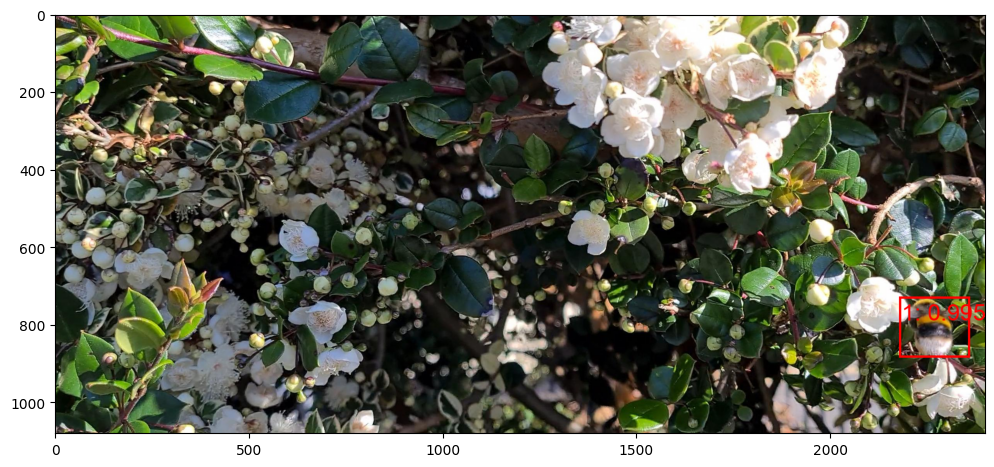

In [21]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

path_img = "/kaggle/input/bee-detection-dataset/test/images/20220708_084534_mp4-48_jpg.rf.25368585d59bdf9bd6db526a84280eff.jpg"
image = read_image(path_img)
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]
    result = nms(pred['boxes'], pred['scores'], iou_threshold=0.1).to('cpu')
    pred = {'labels': pred['labels'][result], 
            'scores': pred['scores'][result], 
            'boxes': pred['boxes'][result, :]}
#image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
pred_labels = [f"{label}: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red",width=6, \
                                   font = '../input/synth-indic-custom-resources/SYNTH_INDIC/fonts/english/English.ttf',\
                                   font_size = 60)


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

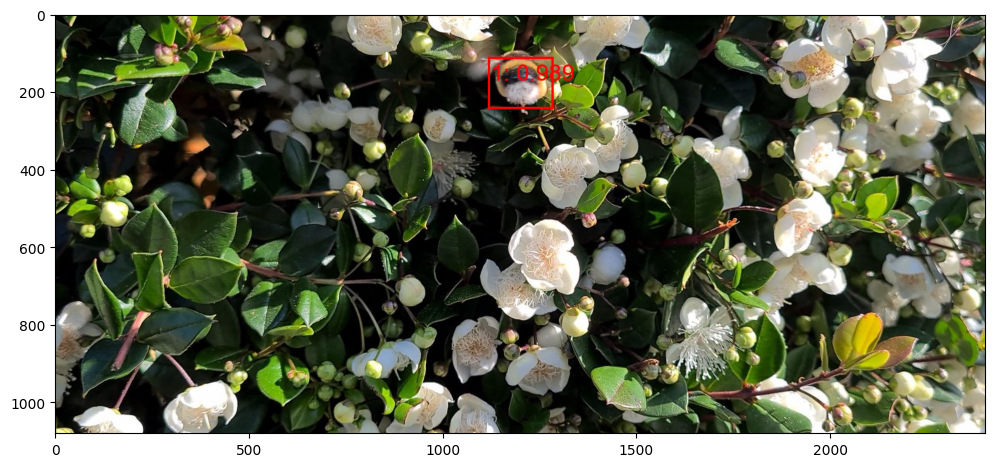

In [22]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

path_img = "/kaggle/input/bee-detection-dataset/test/images/20220708_084920_mp4-131_jpg.rf.ff5859b06e7f5a4e5e3a57aa3b5b436d.jpg"
image = read_image(path_img)
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]
    result = nms(pred['boxes'], pred['scores'], iou_threshold=0.1).to('cpu')
    pred = {'labels': pred['labels'][result], 
            'scores': pred['scores'][result], 
            'boxes': pred['boxes'][result, :]}


#image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"{label}: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red",width=6, \
                                   font = '../input/synth-indic-custom-resources/SYNTH_INDIC/fonts/english/English.ttf',\
                                   font_size = 60)

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))